# __WSI - ćwiczenie 3.__

### __Dwuosobowe gry deterministyczne__


#### __Treść ćwiczenia__

- Celem ćwiczenia jest implementacja algorytmu _min-max_ z przycinaniem $α−β$.
Dla różnych ruchów o tej samej jakości, algorytm powinien zwracać losowy z
nich.
- Następnie należy wykorzystać implementację do porównania jakości dla różnych
głębokości przeszukiwania dla gry kółko i krzyżyk na planszy $N\times N$. W
raporcie powinny być umieszczone wyniki turnieju w grę kółko i krzyżyk, w
którym biorą udział gracze sterowani algorytmem z różnymi głębokościami przeszukiwania.

#### __Opis gry__


_"Gracze obejmują pola na przemian dążąc do objęcia trzech pól w jednej linii, przy jednoczesnym uniemożliwieniu tego samego przeciwnikowi. Pole może być objęte przez jednego gracza i nie zmienia swego właściciela przez cały przebieg gry."_ ~ Wikipedia

#### __Implementacja modelu gry__


In [1]:
import numpy as np
from plotly import graph_objs as go
from plotly.express.colors import sample_colorscale
from plotly.subplots import make_subplots
import pandas as pd
import math
import os
from IPython.display import display, Image, Markdown
from tabulate import tabulate
from enum import Enum
from itertools import permutations, combinations
import copy
import plotly.express as px

RNG = np.random.default_rng()

In [2]:
class BoardOps:

    def _get_heuristic_matrix(self, size_x, size_y):
        board = np.array([[f'{x},{y}' for  y in range(size_y)] for x in range(size_x)])
        all_sequences = (board.tolist() + 
                        np.transpose(board).tolist() + 
                        [board.diagonal(i).tolist() for i in range(-np.shape(board)[0]+1, np.shape(board)[1])] +
                        [np.flip(board, axis=1).diagonal(i).tolist() for i in range(-np.shape(board)[0], np.shape(board)[1])])
        def get_sublists(arr):
            return [arr[i:i+self._win_length] for i in range(len(arr)-self._win_length+1)]
        winning_sequences = [get_sublists(x) for x in all_sequences if len(x) >= self._win_length]
        winning_sequences =  [x for sub in winning_sequences for x in sub]
        def count(target):
            count = 0
            for row in winning_sequences:
                for item in row:
                    if item == target:
                        count += 1
            return count
        
        for y in range(len(board)):
            for x in range(len(board[0])):
                board[y][x] = count(board[y][x])
        return board.astype(int)

    def __init__(self, min_sign: str='O', max_sign: str='X', win_length: int=3, board_size:int=3) -> None:
        self._entry = Enum('ENTRY', ('MIN', 'MAX', 'EMPTY'))
        self._min_sign = min_sign
        self._max_sign = max_sign
        self._win_length = win_length
        self._board_size = board_size
        self._heuristic_matrix = self._get_heuristic_matrix(board_size, board_size)

    def get_str(self, board):
        str_data = board.copy()
        for x in np.ndenumerate(str_data):
            if x[1] == self._entry.MIN:
                str_data[x[0]] = self._min_sign
            elif x[1] == self._entry.MAX:
                str_data[x[0]] = self._max_sign
            elif x[1] == self._entry.EMPTY:
                str_data[x[0]] = ''
        return tabulate(str_data, tablefmt='html')

    def get_str_heuristic(self):
        return tabulate(self._heuristic_matrix, tablefmt='html')

    def _get_cell(self, board, x, y):
        return board[y, x]

    def is_min(self, board, x, y):
        if self._get_cell(x, y) == self._entry.MIN:
            return True
        return False

    def is_max(self, board, x, y):
        if self._get_cell(board, x, y) == self._entry.MAX:
            return True
        return False

    def is_empty(self, board,  x, y):
        if self._get_cell(board, x, y) == self._entry.EMPTY:
            return True
        return False

    def _set_cell(self, board, x, y, input):
        board[y, x] = input

    def set_min(self, board, x, y):
        self._set_cell(board, x, y, self._entry.MIN)

    def set_max(self, board, x, y):
        self._set_cell(board, x, y, self._entry.MAX)

    def set_empty(self, board, x, y):
        self._set_cell(board, x, y, self._entry.EMPTY)

    def generate_empty_board(self):
        return np.full((self._board_size, self._board_size), self._entry.EMPTY)

    def _contains(self, arr, seq):
        for i in range(0, len(arr) - len(seq) + 1):
            if seq == arr[i:i+len(seq)]:
                return True
        return False

    def _check_state(self, arr):
        max_seq = [self._entry.MAX] * self._win_length
        min_seq = [self._entry.MIN] * self._win_length
        if self._contains(arr, max_seq):
            return self._entry.MAX
        if self._contains(arr, min_seq):
            return self._entry.MIN
        return False

    def game_over(self, board):
        all_sequences = (board.tolist() + 
                         np.transpose(board).tolist() + 
                         [board.diagonal(i).tolist() for i in range(-np.shape(board)[0]+1, np.shape(board)[1])] +
                         [np.flip(board, axis=1).diagonal(i).tolist() for i in range(-np.shape(board)[0], np.shape(board)[1])])
        for seq in all_sequences:
            x = self._check_state(seq)
            if x:
                return x
        return False


    def get_win_score(self, board):
        state = self.game_over(board)
        if state == self._entry.MAX:
            return 'max'
        if state == self._entry.MIN:
            return 'min'
        else:
            return 'draw'

    def get_possible_moves(self, board):
        moves = []
        for y in range(np.shape(board)[0]):
            for x in range(np.shape(board)[1]):
                if self.is_empty(board, x, y):
                    moves.append([x, y])
        return moves

    def new_on_max(self, board, x, y):
        new_board = board.copy()
        self.set_max(new_board, x, y)
        return new_board

    def new_on_min(self, board, x, y):
        new_board = board.copy()
        self.set_min(new_board, x, y)
        return new_board
    
    def grade(self, board, coef=1):
        eval = 0
        for x in np.ndenumerate(board):
            value = self._heuristic_matrix[x[0]]
            if x[1] == self._entry.MIN:
                eval -= value * coef
            elif x[1] == self._entry.MAX:
                eval += value * coef
        return eval

    def print(self, board):
        display(Markdown(self.get_str(board)))

    def print_heuristic_matrix(self):
        display(Markdown(self.get_str_heuristic()))

In [3]:
class Game:
    
    def __init__(self, max_algorithm, min_algorithm, max_player_depth, min_player_depth, board_size: int, win_length: int, first_max_move=True, min_sign: str='O', max_sign: str='X'):
        self._board_ops = BoardOps(min_sign, max_sign, win_length, board_size)
        self._board = self._board_ops.generate_empty_board()
        self._board_size = board_size
        self._win_length = win_length
        self._first_max_move = first_max_move
        self._max_move = first_max_move
        self._max_player_depth = max_player_depth
        self._min_player_depth = min_player_depth
        self._min_algorithm = min_algorithm
        self._max_algorithm = max_algorithm

    def is_max_move(self):
        return self._max_move
    
    def change_turn(self):
        self._max_move = not self._max_move

    def reset(self):
        self._board = self._board_ops.generate_empty_board()
        self._max_move = self._first_max_move

    def make_move(self):
        if self.is_max_move():
            self._board_ops.set_max(self._board, *self._max_algorithm(self._board, 
                                                              True, 
                                                              self._board_ops, 
                                                              self._max_player_depth))
        else:
            self._board_ops.set_min(self._board, *self._min_algorithm(self._board, 
                                                              False, 
                                                              self._board_ops, 
                                                              self._min_player_depth))
        self.change_turn()

    def print_board(self):
        self._board_ops.print(self._board)

    def run(self):
        while not self._board_ops.game_over(self._board) and \
            self._board_ops.get_possible_moves(self._board):
                self.make_move()

        return self._board_ops.get_win_score(self._board)

    def run_print(self):
        while not self._board_ops.game_over(self._board) and \
            self._board_ops.get_possible_moves(self._board):
                self.make_move()
                self.print_board()

        return self._board_ops.get_win_score(self._board)

    def run_print_reset(self):
        outcome = self.run_print()
        self.reset()
        return outcome

    def run_reset(self):
        outcome = self.run()
        self.reset()
        return outcome

#### __Algorytm min-max__

In [4]:
def min_max_a_b(board, max_move, board_ops: BoardOps, max_depth=3, payout=math.inf):

    def recurr(board, max_move, depth, alfa, beta):
        if board_ops.game_over(board):
            if max_move:
                return -payout
            return payout
        possible_moves = board_ops.get_possible_moves(board)
        if not possible_moves:
            return 0
        if depth >= max_depth:
            return board_ops.grade(board)
        if max_move:
            value = -math.inf
            for move in possible_moves:
                value = max(value, recurr(board_ops.new_on_max(board, *move), False, depth + 1, alfa, beta))
                alfa = max(alfa, value)
                if value >= beta:
                    break
            return value
        value = math.inf
        for move in possible_moves:
            value = min(value, recurr(board_ops.new_on_min(board, *move), True, depth + 1, alfa, beta))
            beta = min(beta, value)
            if value <= alfa:
                break
        return value

    possible_moves = board_ops.get_possible_moves(board)
    if max_move:
        moves_grades = [(move, recurr(board_ops.new_on_max(board, *move), False, 0, -math.inf, math.inf))
                        for move in possible_moves]
        maxes = [move for move, grade in moves_grades if grade == max(moves_grades, key=lambda x: x[1])[1]]
        return RNG.choice(maxes)
    moves_grades = [(move, recurr(board_ops.new_on_min(board, *move), True, 0, -math.inf, math.inf))
                    for move in possible_moves]
    mins = [move for move, grade in moves_grades if grade == min(moves_grades, key=lambda x: x[1])[1]]
    return RNG.choice(mins)

#### __Funkcja heurystyczna__

In [5]:
BoardOps(win_length=10, board_size=10).print_heuristic_matrix()

<table>
<tbody>
<tr><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td></tr>
<tr><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td></tr>
<tr><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td></tr>
<tr><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td></tr>
<tr><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td></tr>
<tr><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td></tr>
<tr><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td></tr>
<tr><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td></tr>
<tr><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td><td style="text-align: right;">2</td></tr>
<tr><td style="text-align: right;">3</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">2</td><td style="text-align: right;">3</td></tr>
</tbody>
</table>

#### __Przykładowa gra__
plansza 3x3, wygrana przy 3 w rzędzie, głębokość 10 dla obu graczy (pełne pokrycie)

In [6]:
game = Game(min_max_a_b, min_max_a_b, 3, 3, 3, 3)
game.run_print()

<table>
<tbody>
<tr><td></td><td> </td><td></td></tr>
<tr><td></td><td>X</td><td></td></tr>
<tr><td></td><td> </td><td></td></tr>
</tbody>
</table>

<table>
<tbody>
<tr><td> </td><td> </td><td></td></tr>
<tr><td> </td><td>X</td><td></td></tr>
<tr><td>O</td><td> </td><td></td></tr>
</tbody>
</table>

<table>
<tbody>
<tr><td> </td><td> </td><td></td></tr>
<tr><td>X</td><td>X</td><td></td></tr>
<tr><td>O</td><td> </td><td></td></tr>
</tbody>
</table>

<table>
<tbody>
<tr><td> </td><td> </td><td> </td></tr>
<tr><td>X</td><td>X</td><td>O</td></tr>
<tr><td>O</td><td> </td><td> </td></tr>
</tbody>
</table>

<table>
<tbody>
<tr><td> </td><td> </td><td> </td></tr>
<tr><td>X</td><td>X</td><td>O</td></tr>
<tr><td>O</td><td> </td><td>X</td></tr>
</tbody>
</table>

<table>
<tbody>
<tr><td>O</td><td> </td><td> </td></tr>
<tr><td>X</td><td>X</td><td>O</td></tr>
<tr><td>O</td><td> </td><td>X</td></tr>
</tbody>
</table>

<table>
<tbody>
<tr><td>O</td><td>X</td><td> </td></tr>
<tr><td>X</td><td>X</td><td>O</td></tr>
<tr><td>O</td><td> </td><td>X</td></tr>
</tbody>
</table>

<table>
<tbody>
<tr><td>O</td><td>X</td><td> </td></tr>
<tr><td>X</td><td>X</td><td>O</td></tr>
<tr><td>O</td><td>O</td><td>X</td></tr>
</tbody>
</table>

<table>
<tbody>
<tr><td>O</td><td>X</td><td>X</td></tr>
<tr><td>X</td><td>X</td><td>O</td></tr>
<tr><td>O</td><td>O</td><td>X</td></tr>
</tbody>
</table>

'draw'

#### __Kod generujący wykresy__

In [7]:
RUN_AMOUNT = 10
BOARD_SIZE = 5
WIN_LENGTH = 5
df = pd.DataFrame()

pairs = list(permutations(range(4), 2)) + [(x, x) for x in range(5)]
for x, y in pairs:
    g = Game(min_max_a_b, min_max_a_b, x, y, BOARD_SIZE, WIN_LENGTH)
    df[f'max: {x}, min: {y}'] = [g.run_reset() for _ in range(RUN_AMOUNT)]
df

KeyboardInterrupt: 

In [ ]:
sum_df = pd.DataFrame()
for c in df.columns:
    dic = {'min': 0, 'max': 0, 'draw': 0}
    for k, v  in df[c].value_counts().to_dict().items():
        dic[k] = v
    sum_df[c] = dic
sum_df.fillna(value = 0, inplace = True)
sum_df = sum_df.astype(int)
sum_df = sum_df.T

In [ ]:
fig = px.bar(sum_df, barmode='group', template='plotly_dark')
layout = go.Layout(title=f'Results of {RUN_AMOUNT} games on {BOARD_SIZE}x{BOARD_SIZE} board ({WIN_LENGTH} in a row to win) with given search depths',
                   yaxis=dict(title='Result amount'),
                   xaxis=dict(title='Depth configurtation'))
fig.update_layout(layout)
fig.show()

#### __Analiza wydajności algorytmu min-max z funkcją odcięcia alfa-beta w zależności od głębokości przeszukiwania__

Na poniższych wykresach zamieściłem statystyki meczów rozgrywanych między graczami o różnych głębokościach algorytmu min-max.

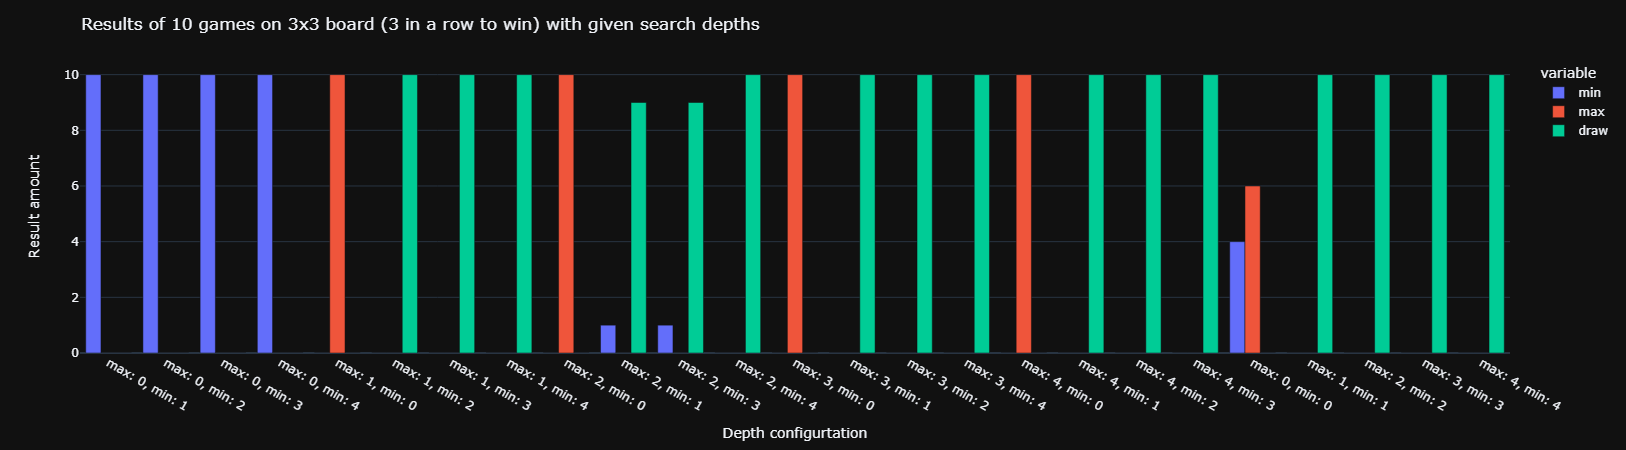

In [ ]:
Image("images/3x3(3).png")

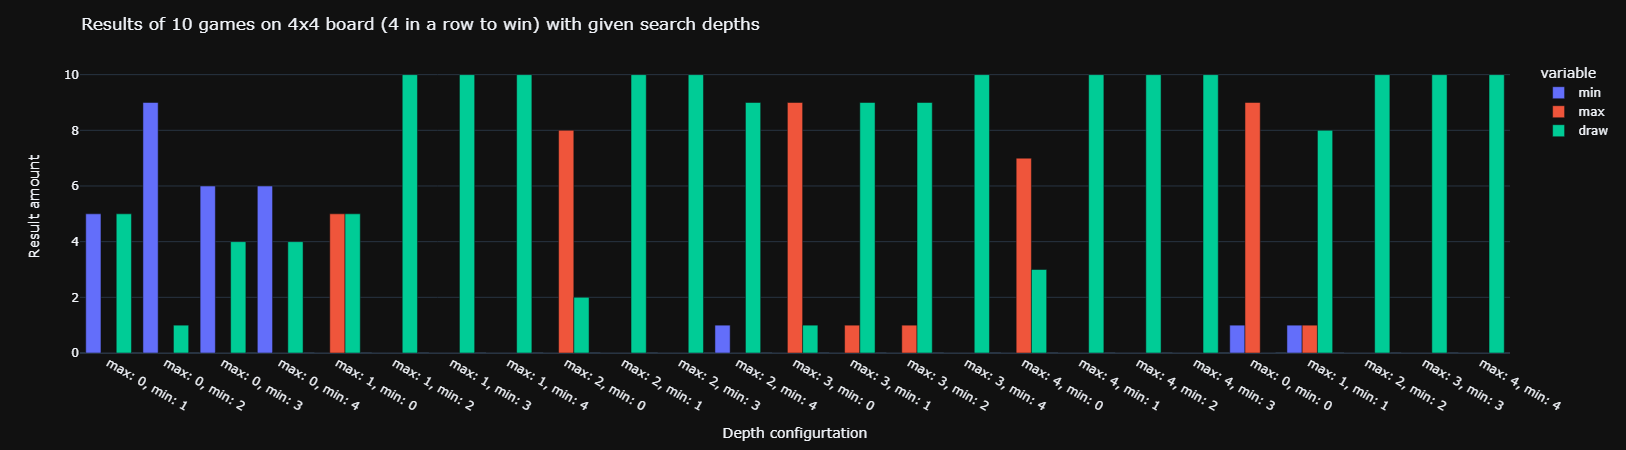

In [ ]:
Image("images/4x4(4).png")

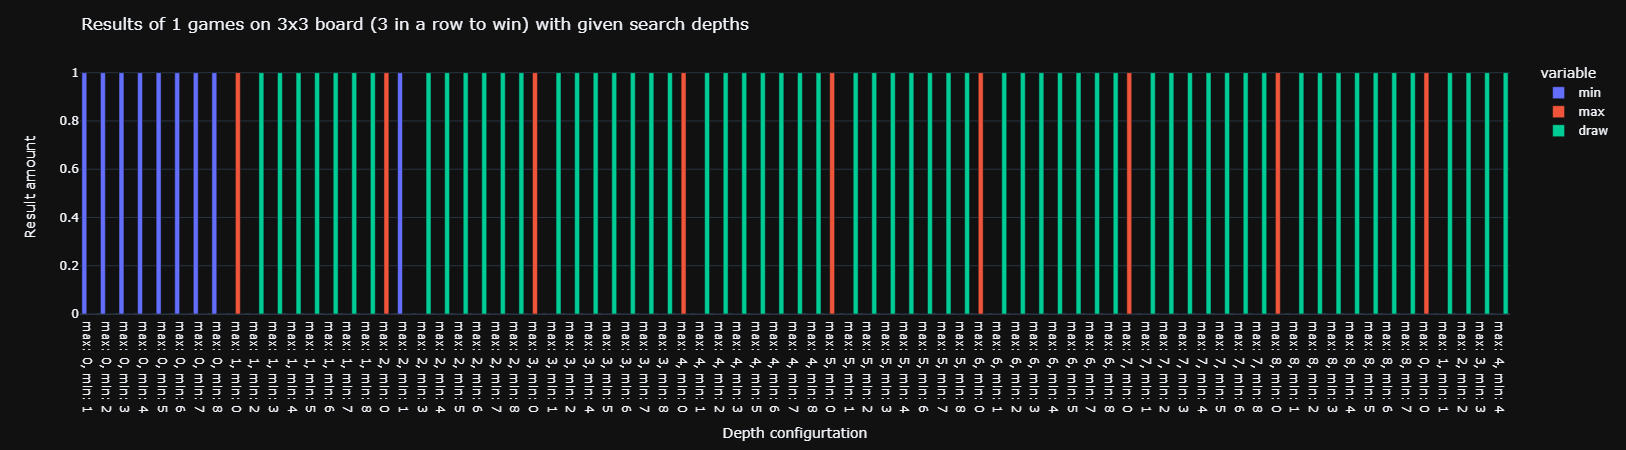

In [ ]:
Image("images/3x3(3)(0-9).png")

__Wnioski__

Zaimplementowany algorytm, co wydaje się logiczne, wygrywa gry częsciej kiedy głębokość przeszukiwania jest większa niż jego przeciwnika. Jednak przy większych głębokościach oraz, w szczególności, ograniczonych przestrzeniach, różnice w głębokości przeszukwiwania rzędu 1-4 mają znikomy wpływ na wyniki. Jest to najprawdopodobniej związane z zasadami rozwiązywanej gry, oraz z niewielką ilością możliwości wygranej. Gracze nawet z małą głębokością przeszukiwania są w stanie skutecznie zapobiec swojej porażce już przy głębokości rzędu 3. Zastanawiający wydaje się także model funkcji heurystycznej. Lepszym rozwiązaniem niż to zaproponowane na wykładzie, byłoby zaimplementowanie dynamicznej heurysstyki, adaptującej się do aktualnie najlepszych ruchów (wyszukiwanie pól o najwyższym potencjale wygranej w aktualnej sytuacji).